**CONV + CONV + attention**

**В этом ноутуке рассматривается сеть с conv1d слоями в энкодере и декодере, реализующая так же attention механизм. Рассматриваются несколько вариантов данной сети:**

*  **с использованием pretrained embeddings и без**
*  **c использованием positional encoding и без**



# Считываем и обрабатываем данные 

In [ ]:
# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.

! pip  install subword-nmt
! pip install nltk
! pip install torchtext

In [ ]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_do_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github. Loading special files as well")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/spring2021/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

Dataset not found locally. Downloading from github. Loading special files as well
--2021-06-05 09:06:52--  https://raw.githubusercontent.com/neychev/made_nlp_course/spring2021/datasets/Machine_translation_EN_RU/data.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12905334 (12M) [text/plain]
Saving to: ‘data.txt’

data.txt            100%[===================>]  12.31M  63.8MB/s    in 0.2s    

2021-06-05 09:06:52 (63.8 MB/s) - ‘data.txt’ saved [12905334/12905334]



In [ ]:
%load_ext autoreload
%autoreload 1
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchtext
from torchtext.legacy.datasets import TranslationDataset, Multi30k
from torchtext.legacy.data import Field, BucketIterator, TabularDataset

import spacy

import random
import math
import time
import numpy as np
import pickle

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [ ]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True,
            batch_first = True)


TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True,
            batch_first = True)

dataset = TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [ ]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.82, 0.15, 0.03], random_state = random.seed(23))

In [ ]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 41000
Number of validation examples: 1500
Number of testing examples: 7500


In [ ]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [ ]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 9427
Unique tokens in target (en) vocabulary: 6777


In [ ]:
os.chdir("/content/drive/MyDrive/MADE/semester2/NLP/lab2/")

In [ ]:
%load_ext autoreload
%autoreload 1
%reload_ext autoreload
os.chdir("/content/drive/MyDrive/MADE/semester2/NLP/lab2/")
import utils
import convolution_pos
import pipeline_func
import imp
imp.reload(utils)
imp.reload(convolution_pos)
imp.reload(pipeline_func)
from  convolution_pos import *
from pipeline_func import *
from utils import *
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Сначала рассмотрим вариант c предообученными embeddings. Возьмем их на основе моделей fasttext. 

## Первоначально, решила подать embeddings на вход, а слой embedding убрать.

In [ ]:
embedding_pretrained = True

if embedding_pretrained:
    with open("/content/drive/MyDrive/MADE/semester2/NLP/cc.ru.300.vec.pickle", "rb") as file_ru:
        ru_emb = pickle.load(file_ru)
       

Не все слова, которые встречаются в текстах, есть среди pretrained. Это чаще всего имена собственные, города, страны и т.д. Решила, что лучше всего в этой ситуации сгенерировать новые случайные embeddings для этих слов

In [ ]:
ru_no_emb = {}
s = 0
for word in SRC.vocab.itos:
  s += 1
  if word not in ru_emb.vocab:
   # print(s)
    #ru_no_emb.update({word : [np.sin(s * np.pi/30 ) for i in range(300)]})
    ru_no_emb.update({word : [random.random() for i in range(300)]})

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
#EMB_DIM = 256
EMB_DIM = 300
HID_DIM = 512 # each conv. layer has 2 * hid_dim filters
ENC_LAYERS = 5 # number of conv. blocks in encoder
DEC_LAYERS = 5 # number of conv. blocks in decoder
ENC_KERNEL_SIZE = 3 # must be odd!
DEC_KERNEL_SIZE = 3 # can be even or odd
ENC_DROPOUT = 0.25
DEC_DROPOUT = 0.25
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

embedding_pretrained = True
    
enc = Encoder(INPUT_DIM, HID_DIM, ENC_LAYERS, ENC_KERNEL_SIZE, ENC_DROPOUT, device,  pos_needed = True,  embedding_pretrained = embedding_pretrained, max_length = 100,  emb_dim = EMB_DIM, remove_emb_layer = True)
dec = Decoder(OUTPUT_DIM, EMB_DIM, HID_DIM, DEC_LAYERS, DEC_KERNEL_SIZE, DEC_DROPOUT, TRG_PAD_IDX, device, pos_needed = True)

model = Seq2Seq(enc, dec).to(device)

300
512


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 20,828,347 trainable parameters


Было замечено, что инициализировать начальные веса нулями, то результат получается хуже, задала дисперсию весов такую, чтобы процесс сходился (когда брала слишком большую дисперсию, иногда начинались проблемы со сходимостью), но был побольше по возможности.

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.03)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (pos_embedding): Embedding(100, 300)
    (emb2hid): Linear(in_features=300, out_features=512, bias=True)
    (hid2emb): Linear(in_features=512, out_features=300, bias=True)
    (convs): ModuleList(
      (0): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (2): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (3): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (4): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
    )
    (dropout): Dropout(p=0.25, inplace=False)
  )
  (decoder): Decoder(
    (tok_embedding): Embedding(6831, 300)
    (pos_embedding): Embedding(100, 300)
    (emb2hid): Linear(in_features=300, out_features=512, bias=True)
    (hid2emb): Linear(in_features=512, out_features=300, bias=True)
    (attn_hid2emb): Linear(in_features=512, out_features=300, bias=True)
    (attn_emb2hid): Linear(

In [ ]:
#print(f'The model has {count_parameters(model):,} trainable parameters')

LEARNING_RATE = 0.001

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, threshold=0.001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)

TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [ ]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [ ]:
train_history = []
valid_history = []

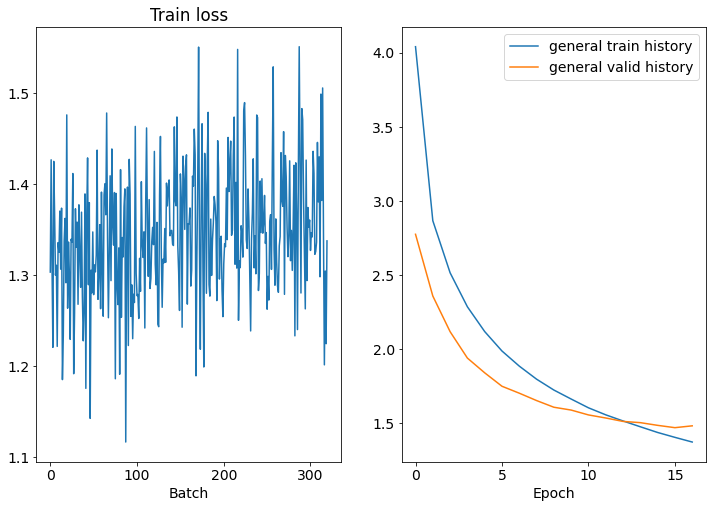

Epoch: 01 | Time: 1m 20s
	Train Loss: 1.345 | Train PPL:   3.838
	 Val. Loss: 1.468 |  Val. PPL:   4.340
CPU times: user 1min 23s, sys: 1.21 s, total: 1min 24s
Wall time: 1min 21s


In [ ]:
%%time
N_EPOCHS = 18
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    #train_loss = train(model, train_iterator, optimizer, criterion, scheduler, CLIP, train_history, valid_history)
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history, None, embedding_pretrained = embedding_pretrained, dicts = (ru_emb, ru_no_emb, SRC.vocab), device = device)
    valid_loss = evaluate(model, valid_iterator, criterion, embedding_pretrained = embedding_pretrained, dicts = (ru_emb, ru_no_emb, SRC.vocab), device = device)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        #torch.save(model.state_dict(), 'tut6-model.pt')
        torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
           },
            os.path.join("/content/drive/MyDrive/MADE/semester2/NLP/lab2/convolution_pos/", f"lab2_transformer_py_best{best_valid_loss}.pt")
           )       
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [ ]:
model_state  = torch.load(("/content/drive/MyDrive/MADE/semester2/NLP/lab2/convolution_pos/lab2_conv_emb_bleu39.0_best.pt")
model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device)
model.load_state_dict(model_state['model_state_dict'])

In [ ]:
test_loss = evaluate(model, test_iterator, criterion,  embedding_pretrained = embedding_pretrained, dicts = (ru_emb, ru_no_emb, SRC.vocab), device = device)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.464 | Test PPL:   4.324 |


In [ ]:
torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
           },
            os.path.join("/content/drive/MyDrive/MADE/semester2/NLP/lab2/convolution_pos", f"lab2_conv_emb_bleu39.0_best.pt")
           )     

In [ ]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import utils
import imp
imp.reload(utils)
from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from nltk.translate.bleu_score import corpus_bleu
import tqdm



**Сделаем переводы на тесте и посчитаем Bleu**

In [ ]:
(original_text, generated_text) = generate_translation_2(model, test_iterator, TRG.vocab, embedding_pretrained, dicts = (ru_emb, ru_no_emb, SRC.vocab))

59it [00:02, 20.52it/s]


In [ ]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

39.832368820353395

In [ ]:
for i, (ot, gt) in enumerate(zip(original_text, generated_text)):
   if (i > 70) and (i < 100):
      print(" ".join(ot))
      print(" ".join(gt))
      print("\n")
   

the property offers free parking .
the property offers free parking .


laundry services are available .
laundry services are available .


there is also a bar .
guests is also a bar .


you will find a 24 - hour front desk at the property .
there will find a 24 - hour front desk at the property .


guests can enjoy the on - site restaurant .
guests can enjoy the on - site restaurant .


you will find a 24 - hour front desk at the property .
there will find a 24 - hour front desk at the property .


the property offers free parking .
the property offers free parking .


some rooms offer a balcony .
some rooms have a balcony .


the apartments are fitted with wooden floors .
the apartment have fitted with wooden floors and


breakfast is served in the restaurant .
breakfast is served in the restaurant .


sauna , massage service and free wi - fi in all areas are available .
massage services massage treatments are massage massage - fi . the units . also .


extras include slippers and to

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**А теперь сделаем переводы на трейне и подсчитаем bleu**

In [ ]:
(original_text_train, generated_text_train) = generate_translation_2(model, train_iterator, TRG.vocab, embedding_pretrained, dicts = (ru_emb, ru_no_emb, SRC.vocab))

321it [00:40,  7.89it/s]


In [ ]:
corpus_bleu([[text] for text in original_text_train], generated_text_train) * 100

49.876143836085504

### Выводы 1


```
  Train Loss: 1.345 | Train PPL:   3.838 | Train Bleu 49.87
	Test Loss: 1.464 | Test PPL:   4.324 |   Text Bleu 39.87
```


**Удачные переводы: (несмотря на высокий достаточно bleu их довольно сложно найти - или дословный перевод или плохой)**

  free parking is possible on site .
  the parking is available on site .

  there is a 24 - hour front desk at the property .|
  there is a 24 - hour front desk at the property .|


**Неудачные переводы:**

the beds are with a mosquito net .
the rooms are provided . tatami net .

the unit is fitted with a kitchen .
you kitchen is equipped with a kitchen .

the 24 - hour front desk also provides basic business services like fax and photocopying .
there reception - hour reception desk can has a 24 . . a . 24 services


**Cкорость обучения модели:**
(число эпох * число обработанных батчей за одну эпоху * размер батча):
10 * 41000 (~321 батчей по 128) 

**время:**
```
Epoch: 18 | Time: 1m 20s
	Train Loss: 1.437 | Train PPL:   4.210
	Val. Loss: 1.486 |  Val. PPL:   4.417
CPU times: user 20min 56s, sys: 20.2 s, total: 21min 16s
Wall time: 20min 31s
```

**Оцените степень переобучения модели**
Как мне кажется, вначале ошибка на train выше, чем на validation, потому что, действует dropout (который выключен на validation). Затем сетка учится и в момент, когда она начинает работать хорошо даже при действии дропаута, то начинается переобучение, графики validation и train пересекаются и validation начинает расти. В этот момент и сохраняется модель. Когда сеть еще не переобучилась. 

**Оцените скорость применения модели в режиме inference** в пересчете на один батч размером 32 (если размер батча необходимо уменьшить, например, до 16, то умножьте усредненный результат на 32/16 = 2)

Для батчей размером 32:
CPU times: user 8.36 s, sys: 455 ms, total: 8.82 s
Wall time: 8.8 s

## А теперь я не буду убирать embedding слой, а просто проинициализирую веса этого слоя матрицей с embeddings

#### Сначала я попробую разморозить все веса с самого сначала

In [ ]:
SRC.vocab.itos

 оставлю его чтобы предтрейненые веса с embeddings подучились под конкретную задачу 

In [ ]:
embedding_matrix = np.zeros((INPUT_DIM, EMB_DIM))
s = 0
for word in SRC.vocab.itos:
  if word in ru_emb.vocab:
    embedding_matrix[s] = ru_emb[word]
  if word in ru_no_emb.keys():
    embedding_matrix[s] = np.random.normal(mean, std, 300)  
  s += 1


#mask = (embedding_matrix[:, 0] == 0.0) # noninitialized vectors
#print(mask)
#mean, std = embedding_matrix[~mask].mean(), embedding_matrix[~mask].std()
#embedding_matrix[mask] = np.random.normal(mean, std, 300)  

In [ ]:
print(embedding_matrix)

[[ 0.05669916  0.00611298 -0.01749976 ... -0.03397038 -0.0665573
   0.01817875]
 [ 0.02622199 -0.03091888  0.02591825 ... -0.02335162  0.00318298
  -0.02949908]
 [ 0.0246204   0.02031607 -0.01863489 ...  0.0084823   0.0319561
  -0.05963541]
 ...
 [ 0.0248      0.0535     -0.0749     ... -0.07       -0.0082
   0.0248    ]
 [ 0.0767      0.0275      0.056      ... -0.0132     -0.0448
  -0.0597    ]
 [ 0.001503   -0.00942876 -0.06699099 ... -0.00851504  0.01206731
   0.00224086]]


In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
#EMB_DIM = 256
EMB_DIM = 300
HID_DIM = 512 # each conv. layer has 2 * hid_dim filters
ENC_LAYERS = 5 # number of conv. blocks in encoder
DEC_LAYERS = 5 # number of conv. blocks in decoder
ENC_KERNEL_SIZE = 3 # must be odd!
DEC_KERNEL_SIZE = 3 # can be even or odd
ENC_DROPOUT = 0.25
DEC_DROPOUT = 0.25
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

EMBEDDING_NO = 0
EMBEDDING_WITHOUT_LAYER = 1
EMBEDDING_WITH_LAYER = 2

embedding_pretrained = EMBEDDING_WITH_LAYER
    
enc = Encoder(INPUT_DIM, HID_DIM, ENC_LAYERS, ENC_KERNEL_SIZE, ENC_DROPOUT, device,  pos_needed = True,  embedding_pretrained = embedding_pretrained, max_length = 100,  emb_dim = EMB_DIM, embedding_matrix = embedding_matrix)
dec = Decoder(OUTPUT_DIM, EMB_DIM, HID_DIM, DEC_LAYERS, DEC_KERNEL_SIZE, DEC_DROPOUT, TRG_PAD_IDX, device, pos_needed = True)

model = Seq2Seq(enc, dec).to(device)

***
111
300
512


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 20,833,155 trainable parameters


In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        print(name)
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.03)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

In [ ]:
model.encoder.tok_embedding.weight.data = torch.from_numpy(embedding_matrix).to(device)
print(model.encoder.tok_embedding.weight)

Parameter containing:
tensor([[ 0.0567,  0.0061, -0.0175,  ..., -0.0340, -0.0666,  0.0182],
        [ 0.0262, -0.0309,  0.0259,  ..., -0.0234,  0.0032, -0.0295],
        [ 0.0246,  0.0203, -0.0186,  ...,  0.0085,  0.0320, -0.0596],
        ...,
        [ 0.0248,  0.0535, -0.0749,  ..., -0.0700, -0.0082,  0.0248],
        [ 0.0767,  0.0275,  0.0560,  ..., -0.0132, -0.0448, -0.0597],
        [ 0.0015, -0.0094, -0.0670,  ..., -0.0085,  0.0121,  0.0022]],
       device='cuda:0', dtype=torch.float64, requires_grad=True)


In [ ]:
for param in model.encoder.tok_embedding.parameters():
   param.requires_grad = True

In [ ]:
#print(f'The model has {count_parameters(model):,} trainable parameters')

LEARNING_RATE = 0.0001

#optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
optimizer = torch.optim.AdamW(model.parameters(), lr = LEARNING_RATE)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, threshold=0.001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 300, eta_min=0, last_epoch=-1, verbose=False)

TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [ ]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [ ]:
train_history = []
valid_history = []

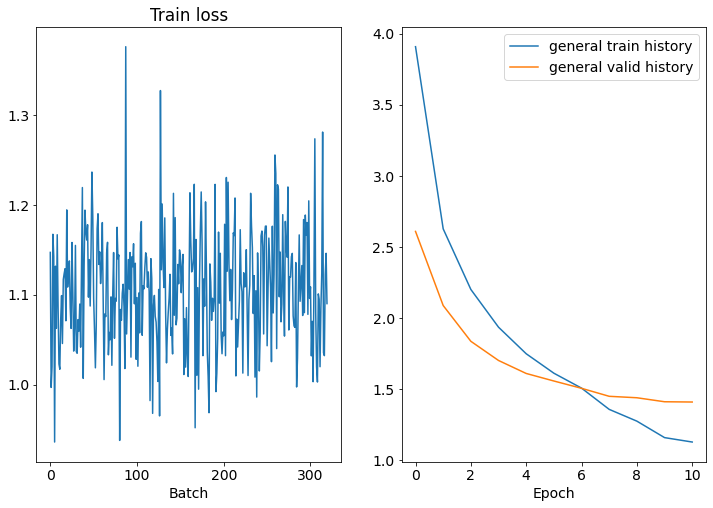

Epoch: 01 | Time: 0m 56s
	Train Loss: 1.105 | Train PPL:   3.020
	 Val. Loss: 1.410 |  Val. PPL:   4.098
CPU times: user 1min 6s, sys: 413 ms, total: 1min 6s
Wall time: 57.3 s


In [ ]:
%%time
N_EPOCHS = 1
CLIP = 1

best_valid_loss = float('inf')
embedding_pretrained = EMBEDDING_WITH_LAYER

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    #train_loss = train(model, train_iterator, optimizer, criterion, scheduler, CLIP, train_history, valid_history)
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history, None, embedding_pretrained = embedding_pretrained, dicts = (ru_emb, ru_no_emb, SRC.vocab), device = device)
    valid_loss = evaluate(model, valid_iterator, criterion, embedding_pretrained = embedding_pretrained, dicts = (ru_emb, ru_no_emb, SRC.vocab), device = device)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        #torch.save(model.state_dict(), 'tut6-model.pt')
        torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
           },
            os.path.join("/content/drive/MyDrive/MADE/semester2/NLP/lab2/convolution_pos/", f"lab2_transformer_py_best{best_valid_loss}.pt")
           )       
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [ ]:
model_state  = torch.load(("/content/drive/MyDrive/MADE/semester2/NLP/lab2/convolution_pos/lab2_conv_emb_bleu39.0_best.pt")
model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device)
model.load_state_dict(model_state['model_state_dict'])

In [ ]:
test_loss = evaluate(model, test_iterator, criterion,  embedding_pretrained = embedding_pretrained, dicts = (ru_emb, ru_no_emb, SRC.vocab), device = device)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.376 | Test PPL:   3.958 |


In [ ]:
torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
           },
            os.path.join("/content/drive/MyDrive/MADE/semester2/NLP/lab2/convolution_pos", f"lab2_conv_emb_bleu39.0_best.pt")
           )     

In [ ]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import utils
import imp
imp.reload(utils)
from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from nltk.translate.bleu_score import corpus_bleu
import tqdm



[autoreload of torch.nn.functional failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
RuntimeError: function 'conv1d' already has a docstring
]


In [ ]:
(original_text, generated_text) = generate_translation_2(model, test_iterator, TRG.vocab, embedding_pretrained, dicts = (ru_emb, ru_no_emb, SRC.vocab))

59it [00:01, 32.45it/s]


In [ ]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

43.489815765279346

In [ ]:
for i, (ot, gt) in enumerate(zip(original_text, generated_text)):
   if (i < 50):
      print(" ".join(ot))
      print(" ".join(gt))
      print("\n")
   

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Выводы

**Получила следующие результаты:**
```
Epoch: 01 | Time: 0m 56s
	Train Loss: 1.105 | Train PPL:   3.020
	 Val. Loss: 1.410 |  Val. PPL:   4.098
   Test Bleu 43.48
```
  
    
      
        
           
             
               
                 
                 

### А теперь сначала заморожу слой с embeddings, поучу немного сеть, а потом разморожу embeddings слои

In [ ]:
embedding_pretrained = True

if embedding_pretrained:
    with open("/content/drive/MyDrive/MADE/semester2/NLP/cc.ru.300.vec.pickle", "rb") as file_ru:
        ru_emb = pickle.load(file_ru)
       

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
#EMB_DIM = 256
EMB_DIM = 300
HID_DIM = 512 # each conv. layer has 2 * hid_dim filters
ENC_LAYERS = 5 # number of conv. blocks in encoder
DEC_LAYERS = 5 # number of conv. blocks in decoder
ENC_KERNEL_SIZE = 3 # must be odd!
DEC_KERNEL_SIZE = 3 # can be even or odd
ENC_DROPOUT = 0.25
DEC_DROPOUT = 0.25
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

In [ ]:
ru_emb

In [ ]:
embedding_matrix = np.zeros((INPUT_DIM, EMB_DIM))

s = 0
for word in SRC.vocab.itos:
  if word in ru_emb.vocab:
    embedding_matrix[s] = ru_emb[word]
  s += 1  
print(embedding_matrix)

mask = (embedding_matrix[:, 0] == 0.0) # noninitialized vectors
mean, std = embedding_matrix[~mask].mean(), embedding_matrix[~mask].std()
print(mean, std)

s = 0
for word in SRC.vocab.itos:
  if word not in ru_emb.vocab:
    embedding_matrix[s] = np.random.normal(mean, std, 300) 
  s += 1

 # else:
 #   embedding_matrix[s] = np.random.normal(mean, std, 300)  
 # s += 1


#mask = (embedding_matrix[:, 0] == 0.0) # noninitialized vectors
#print(mask)
#mean, std = embedding_matrix[~mask].mean(), embedding_matrix[~mask].std()
#embedding_matrix[mask] = np.random.normal(mean, std, 300)  

In [ ]:
print(embedding_matrix)

[[-0.09514892  0.00491439  0.08303476 ...  0.05333107 -0.00151497
  -0.16577199]
 [ 0.01699471 -0.12840088 -0.08411249 ... -0.05526059 -0.04001554
   0.13873185]
 [ 0.05404167 -0.01515083 -0.02669468 ... -0.02815735  0.03531553
  -0.02490573]
 ...
 [ 0.0082     -0.0019      0.0387     ... -0.0283     -0.0678
  -0.0402    ]
 [ 0.0306      0.17110001  0.1129     ...  0.0351     -0.078
  -0.0653    ]
 [ 0.1874     -0.2309      0.13060001 ... -0.0752     -0.1841
  -0.0004    ]]


In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
#EMB_DIM = 256
EMB_DIM = 300
HID_DIM = 512 # each conv. layer has 2 * hid_dim filters
ENC_LAYERS = 5 # number of conv. blocks in encoder
DEC_LAYERS = 5 # number of conv. blocks in decoder
ENC_KERNEL_SIZE = 3 # must be odd!
DEC_KERNEL_SIZE = 3 # can be even or odd
ENC_DROPOUT = 0.25
DEC_DROPOUT = 0.25
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

EMBEDDING_NO = 0
EMBEDDING_WITHOUT_LAYER = 1
EMBEDDING_WITH_LAYER = 2

embedding_pretrained = EMBEDDING_WITH_LAYER
    
enc = Encoder(INPUT_DIM, HID_DIM, ENC_LAYERS, ENC_KERNEL_SIZE, ENC_DROPOUT, device,  pos_needed = True,  embedding_pretrained = embedding_pretrained, max_length = 100,  emb_dim = EMB_DIM, embedding_matrix = embedding_matrix)
dec = Decoder(OUTPUT_DIM, EMB_DIM, HID_DIM, DEC_LAYERS, DEC_KERNEL_SIZE, DEC_DROPOUT, TRG_PAD_IDX, device, pos_needed = True)

model = Seq2Seq(enc, dec).to(device)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 20,833,155 trainable parameters


In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        #print(name)
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.03)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

In [ ]:
for param in model.encoder.tok_embedding.parameters():
   param.requires_grad = True

In [ ]:
#print(f'The model has {count_parameters(model):,} trainable parameters')

LEARNING_RATE = 0.00001

#optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
optimizer = torch.optim.AdamW(model.parameters(), lr = LEARNING_RATE)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, threshold=0.001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 300, eta_min=0, last_epoch=-1, verbose=False)

TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [ ]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [ ]:
train_history = []
valid_history = []

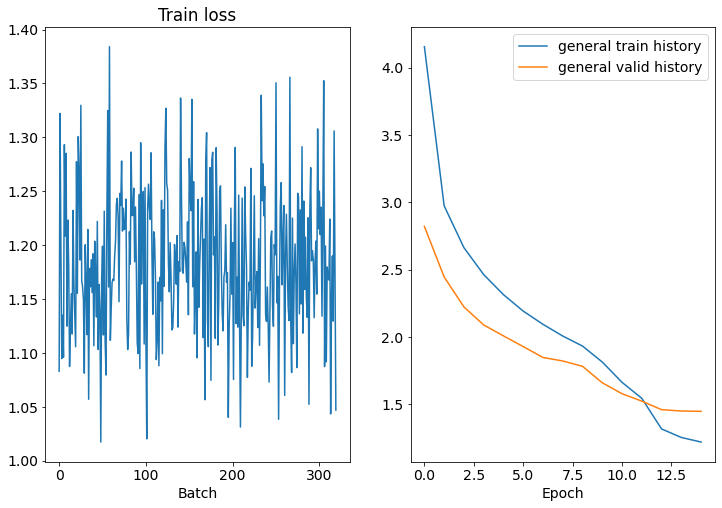

Epoch: 01 | Time: 0m 39s
	Train Loss: 1.183 | Train PPL:   3.266
	 Val. Loss: 1.443 |  Val. PPL:   4.232
CPU times: user 47.4 s, sys: 567 ms, total: 47.9 s
Wall time: 39.9 s


In [ ]:
%%time
N_EPOCHS = 1
CLIP = 1

best_valid_loss = float('inf')
embedding_pretrained = EMBEDDING_WITH_LAYER

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    #train_loss = train(model, train_iterator, optimizer, criterion, scheduler, CLIP, train_history, valid_history)
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history, None, embedding_pretrained = embedding_pretrained) 
    valid_loss = evaluate(model, valid_iterator, criterion, embedding_pretrained = embedding_pretrained)
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        #torch.save(model.state_dict(), 'tut6-model.pt')
        torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
           },
            os.path.join("/content/drive/MyDrive/MADE/semester2/NLP/lab2/convolution_pos/", f"lab2_transformer_py_best{best_valid_loss}.pt")
           )       
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [ ]:
model_state  = torch.load(("/content/drive/MyDrive/MADE/semester2/NLP/lab2/convolution_pos/lab2_conv_emb_bleu39.0_best.pt")
model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device)
model.load_state_dict(model_state['model_state_dict'])

In [ ]:
test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.523 | Test PPL:   4.588 |


In [ ]:
torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
           },
            os.path.join("/content/drive/MyDrive/MADE/semester2/NLP/lab2/convolution_pos", f"lab2_conv_emb_after_freeze37.pt")
           )     

In [ ]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import utils
import imp
imp.reload(utils)
from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from nltk.translate.bleu_score import corpus_bleu
import tqdm



In [ ]:
(original_text, generated_text) = generate_translation_2(model, test_iterator, TRG.vocab)

59it [00:01, 46.99it/s]


In [ ]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

37.67958678220818

***Получились следующие результаты:***
```
Epoch: 01 | Time: 0m 39s
	Train Loss: 1.183 | Train PPL:   3.266
	 Val. Loss: 1.443 |  Val. PPL:   4.232
   Test bleu: 37.679
```

# А теперь обучим модель без предобученных embeddings но все еще с positional encoding

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
#EMB_DIM = 256
EMB_DIM = 300
HID_DIM = 512 # each conv. layer has 2 * hid_dim filters
ENC_LAYERS = 5 # number of conv. blocks in encoder
DEC_LAYERS = 5 # number of conv. blocks in decoder
ENC_KERNEL_SIZE = 3 # must be odd!
DEC_KERNEL_SIZE = 3 # can be even or odd
ENC_DROPOUT = 0.25
DEC_DROPOUT = 0.25
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

embedding_pretrained = False
    
enc = Encoder(INPUT_DIM, HID_DIM, ENC_LAYERS, ENC_KERNEL_SIZE, ENC_DROPOUT, device,  pos_needed = True,  embedding_pretrained = embedding_pretrained, max_length = 100,  emb_dim = EMB_DIM)
dec = Decoder(OUTPUT_DIM, EMB_DIM, HID_DIM, DEC_LAYERS, DEC_KERNEL_SIZE, DEC_DROPOUT, TRG_PAD_IDX, device, pos_needed = True)

model = Seq2Seq(enc, dec).to(device)

300
512


In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.03)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (tok_embedding): Embedding(9399, 300)
    (pos_embedding): Embedding(100, 300)
    (emb2hid): Linear(in_features=300, out_features=512, bias=True)
    (hid2emb): Linear(in_features=512, out_features=300, bias=True)
    (convs): ModuleList(
      (0): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (2): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (3): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (4): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
    )
    (dropout): Dropout(p=0.25, inplace=False)
  )
  (decoder): Decoder(
    (tok_embedding): Embedding(6825, 300)
    (pos_embedding): Embedding(100, 300)
    (emb2hid): Linear(in_features=300, out_features=512, bias=True)
    (hid2emb): Linear(in_features=512, out_features=300, bias=True)
    (attn_hid2emb): Linear(in_features=512, out_features=3

In [ ]:
#print(f'The model has {count_parameters(model):,} trainable parameters')

LEARNING_RATE = 0.001

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, threshold=0.001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)

TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [ ]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [ ]:
train_history = []
valid_history = []

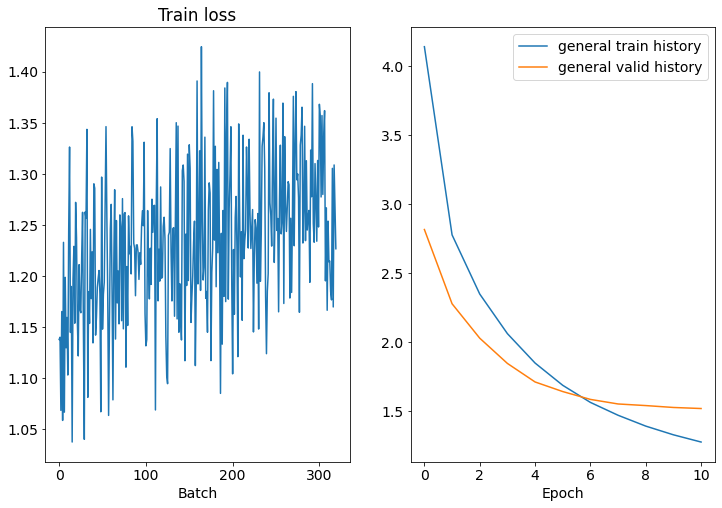

Epoch: 12 | Time: 0m 59s
	Train Loss: 1.234 | Train PPL:   3.433
	 Val. Loss: 1.514 |  Val. PPL:   4.546
CPU times: user 12min 23s, sys: 11.7 s, total: 12min 35s
Wall time: 12min 1s


In [ ]:
%%time
N_EPOCHS = 12#10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    #train_loss = train(model, train_iterator, optimizer, criterion, scheduler, CLIP, train_history, valid_history)
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        #torch.save(model.state_dict(), 'tut6-model.pt')
        torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
           },
            os.path.join("/content/drive/MyDrive/MADE/semester2/NLP/lab2/convolution_pos/", f"lab2_transformer_py_best{best_valid_loss}.pt")
           )       
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [ ]:
model1 = model

In [ ]:
model_state  = torch.load("/content/drive/MyDrive/MADE/semester2/NLP/lab2/convolution_pos/lab2_conv_no_emb_best41.3.pt")
#model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device)
model.load_state_dict(model_state['model_state_dict'])

In [ ]:
model = model1

In [ ]:
test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.465 | Test PPL:   4.328 |


In [ ]:
torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
           },
            os.path.join("/content/drive/MyDrive/MADE/semester2/NLP/lab2/convolution_pos", f"lab2_conv_no_emb_no_pos40.3.pt")
           )     

In [ ]:
(original_text, generated_text) = generate_translation_2(model, test_iterator, TRG.vocab)

59it [00:01, 30.46it/s]


In [ ]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

41.94427317245696

In [ ]:
for i, (ot, gt) in enumerate(zip(original_text, generated_text)):
   if (i > 70) and (i < 150):
      print(" ".join(ot))
      print(" ".join(gt))
      print("\n")
   

there is a shared kitchen at the property .
there is a shared kitchen at the property .


there is a 24 - hour front desk at the property .
there is a 24 - hour front desk at the property .


the kitchen features a microwave .
the kitchen is a microwave .


there is a 24 - hour front desk at the property .
there is a 24 - hour front desk at the property .


this hotel does not have a restaurant .
guests hotel does not restaurant a restaurant .


there is a 24 - hour front desk at the property .
there is a 24 - hour front desk at the property .


there is a 24 - hour front desk at the property .
there is a 24 - hour front desk at the property .


free parking is available .
the parking is available .


the property offers free parking .
the property offers free parking .


on - site parking is free for guests .
the - site parking is free . guests .


bathrobes are provided free of charge .
bathrobes are available for of charge .


the property offers free parking .
the property offers f

In [ ]:
(original_text_train, generated_text_train) = generate_translation_2(model, train_iterator, TRG.vocab)

321it [00:17, 18.03it/s]


In [ ]:
corpus_bleu([[text] for text in original_text_train], generated_text_train) * 100

49.8039060055667

### Выводы 2


```
  Train Loss: 1.237 | Train PPL:   3.444 | Bleu 41.94
	Test Loss: 1.465 | Test PPL:   4.328 | Bleu 51.45
```


**Удачные переводы: (Здесь ситуация аналогичная, несмотря на высокий достаточно bleu их довольно сложно найти - или дословный перевод или плохой)**  
packed lunches can be provided upon request .  
packed lunches can be requested upon request .   


**Неудачные переводы:**

sauna , massage service and free wi - fi in all areas are available .   
massage can and services is a weights - fi . the areas . also .

a free airport service is provided .
a shuttle shuttle shuttle is is available .


**Cкорость обучения модели:**
(число эпох * число обработанных батчей за одну эпоху * размер батча):
10 * 41000 (~321 батчей по 128) 

**время:**
```
Epoch: 12 | Time: 0m 59s
	Train Loss: 1.237 | Train PPL:   3.444
	 Val. Loss: 1.456 |  Val. PPL:   4.287
CPU times: user 12min 32s, sys: 11.3 s, total: 12min 44s
Wall time: 12min 9s
```

**Оцените скорость применения модели в режиме inference** в пересчете на один батч размером 32 (если размер батча необходимо уменьшить, например, до 16, то умножьте усредненный результат на 32/16 = 2)

Для батчей размером 32:
CPU times: user 8.36 s, sys: 455 ms, total: 8.82 s
Wall time: 8.8 s

# А теперь уберем еще и positional encoding

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
#EMB_DIM = 256
EMB_DIM = 300
HID_DIM = 512 # each conv. layer has 2 * hid_dim filters
ENC_LAYERS = 5 # number of conv. blocks in encoder
DEC_LAYERS = 5 # number of conv. blocks in decoder
ENC_KERNEL_SIZE = 3 # must be odd!
DEC_KERNEL_SIZE = 3 # can be even or odd
ENC_DROPOUT = 0.25
DEC_DROPOUT = 0.25
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

embedding_pretrained = False
pos_needed = False
    
enc = Encoder(INPUT_DIM, HID_DIM, ENC_LAYERS, ENC_KERNEL_SIZE, ENC_DROPOUT, device,  pos_needed = pos_needed,  embedding_pretrained = embedding_pretrained, max_length = 100,  emb_dim = EMB_DIM)
dec = Decoder(OUTPUT_DIM, EMB_DIM, HID_DIM, DEC_LAYERS, DEC_KERNEL_SIZE, DEC_DROPOUT, TRG_PAD_IDX, device, pos_needed = pos_needed)

model = Seq2Seq(enc, dec).to(device)

300
512


In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.03)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (tok_embedding): Embedding(9412, 300)
    (emb2hid): Linear(in_features=300, out_features=512, bias=True)
    (hid2emb): Linear(in_features=512, out_features=300, bias=True)
    (convs): ModuleList(
      (0): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (2): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (3): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (4): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
    )
    (dropout): Dropout(p=0.25, inplace=False)
  )
  (decoder): Decoder(
    (tok_embedding): Embedding(6831, 300)
    (emb2hid): Linear(in_features=300, out_features=512, bias=True)
    (hid2emb): Linear(in_features=512, out_features=300, bias=True)
    (attn_hid2emb): Linear(in_features=512, out_features=300, bias=True)
    (attn_emb2hid): Linear(in_features=300, out_features=512, bias=

In [ ]:
#print(f'The model has {count_parameters(model):,} trainable parameters')

LEARNING_RATE = 0.001

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, threshold=0.001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)

TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [ ]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [ ]:
train_history = []
valid_history = []

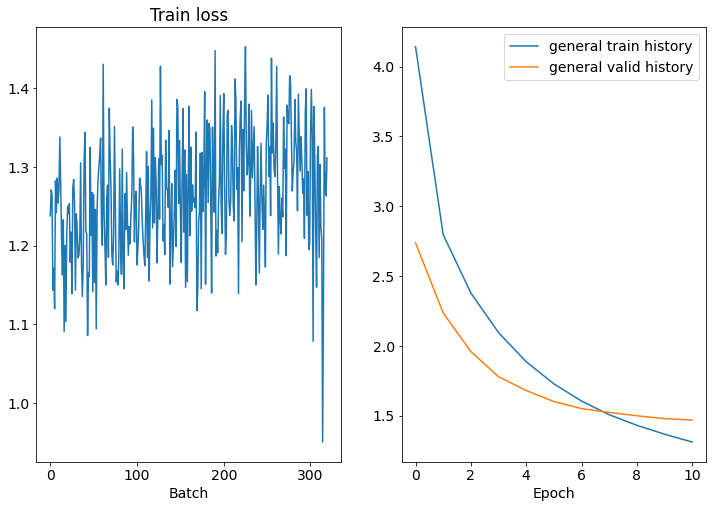

Epoch: 12 | Time: 0m 58s
	Train Loss: 1.263 | Train PPL:   3.536
	 Val. Loss: 1.456 |  Val. PPL:   4.289
CPU times: user 12min 26s, sys: 10.8 s, total: 12min 36s
Wall time: 12min 2s


In [ ]:
%%time
N_EPOCHS = 12#10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    #train_loss = train(model, train_iterator, optimizer, criterion, scheduler, CLIP, train_history, valid_history)
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history, None, embedding_pretrained = embedding_pretrained, dicts = (ru_emb, ru_no_emb, SRC.vocab), device = device)
    valid_loss = evaluate(model, valid_iterator, criterion, embedding_pretrained = embedding_pretrained, dicts = (ru_emb, ru_no_emb, SRC.vocab), device = device)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        #torch.save(model.state_dict(), 'tut6-model.pt')
        torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
           },
            os.path.join("/content/drive/MyDrive/MADE/semester2/NLP/lab2/convolution_pos/", f"lab2_transformer_py_best{best_valid_loss}.pt")
           )       
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [ ]:
#model_state  = torch.load(("/content/drive/MyDrive/MADE/semester2/NLP/lab2/convolution_pos/lab2_conv_no_emb.pt")
#model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device)
#model.load_state_dict(model_state['model_state_dict'])

In [ ]:
test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.469 | Test PPL:   4.343 |


In [ ]:
torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
           },
            os.path.join("/content/drive/MyDrive/MADE/semester2/NLP/lab2/convolution_pos", f"lab2_conv_no_emb_no_pos.pt")
           )     

In [ ]:
(original_text, generated_text) = generate_translation_2(model, test_iterator, TRG.vocab)

59it [00:01, 30.91it/s]


In [ ]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

40.3464340694586

In [ ]:
(original_text_train, generated_text_train) = generate_translation_2(model, train_iterator, TRG.vocab)

321it [00:18, 17.00it/s]


In [ ]:
corpus_bleu([[text] for text in original_text_train], generated_text_train) * 100

49.78329127264692

### Выводы 


```
  Train Loss: 1.263 | Train PPL:   3.536 | Bleu 49.78329
  Test Loss: 1.469  | Test PPL:   4.343  | Bleu 40.3464
```

**Cкорость обучения модели:**
(число эпох * число обработанных батчей за одну эпоху * размер батча):
10 * 41000 (~321 батчей по 128) 

**время:**
```
Epoch: 12 | Time: 0m 58s
 	 Train Loss: 1.263 | Train PPL:   3.536
	 Val. Loss: 1.456 |  Val. PPL:   4.289
CPU times: user 12min 26s, sys: 10.8 s, total: 12min 36s
Wall time: 12min 2s
```

**Оцените скорость применения модели в режиме inference** в пересчете на один батч размером 32 (если размер батча необходимо уменьшить, например, до 16, то умножьте усредненный результат на 32/16 = 2)

Для батчей размером 32:
CPU times: user 8.36 s, sys: 455 ms, total: 8.82 s
Wall time: 8.8 s

# **ВЫВОДЫ ОБЩИЕ**

**Были рассмотрены 3 модели на основе conv1d слоев с реализованным механизмом attention: C и БЕЗ predtrained embedding + С positional encoding, и БЕЗ predtrained embedding + БЕЗ positional encoding.**

**Модель без predtrained embeddings и  без positional encoding дала самый худший результат :**
```
  Train Loss: 1.263 | Train PPL:   3.536 | Bleu 49.78329
  Test Loss: 1.469  | Test PPL:   4.343  | Bleu 40.3464
```


**Модель без predtrained embeddings и  c positional encoding дала результат лучше, чем когда не было positional embedding**
```

  Train Loss: 1.237 | Train PPL:   3.444 | Bleu 51.45
	Test Loss: 1.465 | Test PPL:   4.328 | 
     
     Bleu 41.94

```


**Далее все перечисленные модели будут с positional encodding:**

**Модель с predtrained embeddings, где предобученные embeddings просто поступает на вход без возможности их обучения:**
```
 Train Loss: 1.345 | Train PPL:   3.838 | Train Bleu 49.87
    Test Loss: 1.464 | Test PPL:   4.324 |     


 Text Bleu 39.87
```

**Модель с predtrained embeddings, где с помощью embeddings инициализируются веса и затем дообучаются. Причем все веса сразу размораживаются. Тут получился самый лучший результат:**
```
Epoch: 01 | Time: 0m 56s
    Train Loss: 1.105 | Train PPL:   3.020
     Val. Loss: 1.410 |  Val. PPL:   4.098  
      

   Test Bleu 43.48
```

**Модель с predtrained embeddings, где с помощью предобученных embeddings инициализируются веса и затем дообучаются. Причем слой с embeddings первончально замораживается и только после того, как лосс немнного уменьшается и скорость его падения уменьшается,  веса embedding слоя размораживаются: Здесь получились результаты немного хуже, чем если разморозить все сразу - возможно в неумелых руках**.
```
Epoch: 01 | Time: 0m 39s
	Train Loss: 1.183 | Train PPL:   3.266
	 Val. Loss: 1.443 |  Val. PPL:   4.232  
          

   Test bleu: 37.679
```


**В данной работае Bleu был подсчитан мною неверно, как мне теперь кажется.  Потому, при рассчете на вход модели подавался target, и в модели при переводе текста использовалась информация о реальном target Переделывать  уже не стала. По любому ориентировалась на падение лосса и PPL при своих рассуждениях. В отдельном ноутбуке (lab_convolution_embedding.ipynb) пересчитала BLEU для лучшей модели верным способом.**